A política aprendida com Q-learning linear está representada com setas nos estados não terminais, enquanto os estados terminais (+1, –1) e a parede são indicados com cores.

In [95]:
# Linear Q-learning with Replay Buffer and 2 features: distance to goal and to bad state

from collections import deque
import random

from matplotlib import pyplot as plt
import numpy as np


class LinearQReplaySimple:
    def __init__(self, actions, params):
        self.actions = actions
        self.alpha = params['alpha']
        self.gamma = params['gamma']
        self.epsilon = params['epsilon_start']
        self.epsilon_min = params['epsilon_end']
        self.decay = params['epsilon_decay']
        self.batch_size = params['batch_size']
        self.buffer = deque(maxlen=params['buffer_size'])
        self.goal = params['goal']
        self.bad = params['bad']
        self.weights = np.zeros(3 + len(actions))  # 2 features + one-hot for action
        self.action_index = {a: i for i, a in enumerate(actions)}

    def featurize(self, state, action):
        dx, dy = action_vectors[action]
        nx, ny = state[0] + dx, state[1] + dy
        gx, gy = self.goal
        self.max_dist = 5
        rel_x = (nx - gx) / self.max_dist
        rel_y = (ny - gy) / self.max_dist
        action_one_hot = [int(action == a) for a in self.actions]
        return np.array([1, rel_x, rel_y] + action_one_hot)  # bias term added

    def predict(self, state, action):
        phi = self.featurize(state, action)
        return np.dot(self.weights, phi)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return max(self.actions, key=lambda a: self.predict(state, a))

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.buffer) < self.batch_size:
            return
        batch = random.sample(self.buffer, self.batch_size)
        for state, action, reward, next_state, done in batch:
            phi = self.featurize(state, action)
            q_sa = np.dot(self.weights, phi)
            if done:
                target = reward
            else:
                target = reward + self.gamma * max(self.predict(next_state, a) for a in self.actions)
            self.weights += self.alpha * (target - q_sa) * phi

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * np.exp(-self.decay))

    def get_policy(self, cols, rows, walls, terminals):
        policy = {}
        for x in range(1, cols + 1):
            for y in range(1, rows + 1):
                if (x, y) in walls or (x, y) in terminals:
                    continue
                state = (x, y)
                best_action = max(self.actions, key=lambda a: self.predict(state, a))
                policy[state] = best_action
        return policy

# Hyperparameter dictionary
params = {
    'gamma': 0.9,
    'alpha': 0.001,
    'epsilon_start': 1.0,
    'epsilon_end': 0.0,
    'epsilon_decay': 0.001,
    'buffer_size': 5000,
    'batch_size': 64,
    'goal': (4, 3),
    'bad': (4, 2)
}

# Define environment config
cols, rows = 4, 3
start_state = (1, 1)
walls = {(2, 2)}
terminals = {(4, 3): +1, (4, 2): -1}
actions = ['up', 'down', 'left', 'right']
action_vectors = {'up': (0, 1), 'down': (0, -1), 'left': (-1, 0), 'right': (1, 0)}

def get_possible_moves(action):
    if action == 'up':
        return [('up', 0.8), ('left', 0.1), ('right', 0.1)]
    elif action == 'down':
        return [('down', 0.8), ('left', 0.1), ('right', 0.1)]
    elif action == 'left':
        return [('left', 0.8), ('up', 0.1), ('down', 0.1)]
    elif action == 'right':
        return [('right', 0.8), ('up', 0.1), ('down', 0.1)]

def move(state, action):
    moves = get_possible_moves(action)
    chosen = random.choices(moves, weights=[p for _, p in moves])[0][0]
    dx, dy = action_vectors[chosen]
    nx, ny = state[0] + dx, state[1] + dy
    if (nx, ny) in walls or not (1 <= nx <= cols and 1 <= ny <= rows):
        return state
    return (nx, ny)

# Train the agent
agent = LinearQReplaySimple(actions, params)
episodes = 15000
max_steps = 50
living_reward = -0.1
episode_rewards = []

for ep in range(episodes):
    state = start_state
    total_reward = 0
    for _ in range(max_steps):
        action = agent.choose_action(state)
        next_state = move(state, action)
        reward = terminals.get(next_state, living_reward)
        done = next_state in terminals
        agent.store(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay()
    agent.decay_epsilon()
    episode_rewards.append(total_reward)

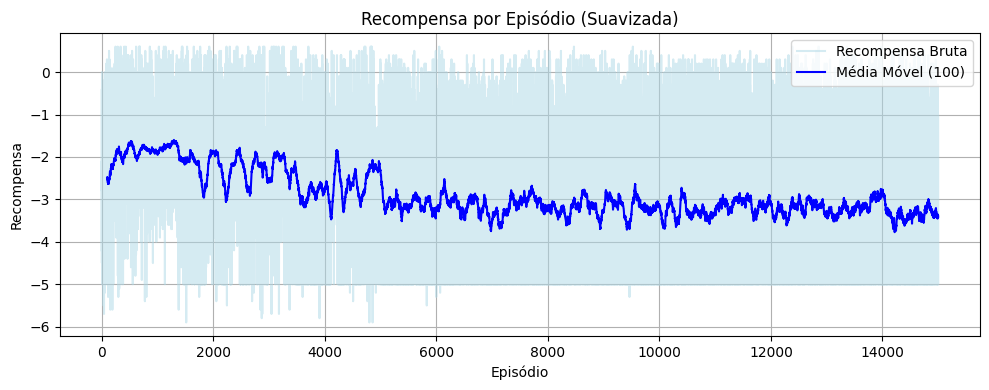

In [96]:
# Aplicar média móvel para suavizar a curva de recompensas por episódio

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 100
smoothed_rewards = moving_average(episode_rewards, window_size)

plt.figure(figsize=(10, 4))
plt.plot(episode_rewards, color='lightblue', alpha=0.5, label="Recompensa Bruta")
plt.plot(np.arange(window_size - 1, len(episode_rewards)), smoothed_rewards, color='blue', label=f"Média Móvel ({window_size})")
plt.xlabel("Episódio")
plt.ylabel("Recompensa")
plt.title("Recompensa por Episódio (Suavizada)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Novas *features*

In [97]:
# Re-import all necessary modules and reinitialize environment after kernel reset
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

# Grid-world setup
cols, rows = 4, 3
start_state = (1, 1)
walls = {(2, 2)}
terminals = {(4, 3): +1, (4, 2): -1}
actions = ['up', 'down', 'left', 'right']
action_vectors = {'up': (0, 1), 'down': (0, -1), 'left': (-1, 0), 'right': (1, 0)}

# Parameters dictionary
params = {
    'alpha': 0.05,
    'gamma': 0.95,
    'epsilon_start': 1.0,
    'epsilon_end': 0.05,
    'epsilon_decay': 0.002,
    'buffer_size': 5000,
    'batch_size': 64,
    'goal': (4, 3),
    'bad': (4, 2)
}
living_reward = -0.01

# Environment dynamics
def get_possible_moves(action):
    if action == 'up':
        return [('up', 0.8), ('left', 0.1), ('right', 0.1)]
    elif action == 'down':
        return [('down', 0.8), ('left', 0.1), ('right', 0.1)]
    elif action == 'left':
        return [('left', 0.8), ('up', 0.1), ('down', 0.1)]
    elif action == 'right':
        return [('right', 0.8), ('up', 0.1), ('down', 0.1)]

def move(state, action):
    moves = get_possible_moves(action)
    chosen = random.choices(moves, weights=[p for _, p in moves])[0][0]
    dx, dy = action_vectors[chosen]
    nx, ny = state[0] + dx, state[1] + dy
    if (nx, ny) in walls or not (1 <= nx <= cols and 1 <= ny <= rows):
        return state
    return (nx, ny)

# Agent class with enhanced feature representation
class LinearQReplayRelPosBiasAligned:
    def __init__(self, actions, params):
        self.actions = actions
        self.alpha = params['alpha']
        self.gamma = params['gamma']
        self.epsilon = params['epsilon_start']
        self.epsilon_min = params['epsilon_end']
        self.decay = params['epsilon_decay']
        self.batch_size = params['batch_size']
        self.buffer = deque(maxlen=params['buffer_size'])
        self.goal = params['goal']
        self.max_dist = (cols - 1) + (rows - 1)
        self.weights = np.zeros(5 + len(actions))  # bias + rel_x + rel_y + aligned_x + aligned_y + one-hot
        self.action_index = {a: i for i, a in enumerate(actions)}

    def featurize(self, state, action):
        dx, dy = action_vectors[action]
        nx, ny = state[0] + dx, state[1] + dy
        gx, gy = self.goal
        rel_x = (nx - gx) / self.max_dist
        rel_y = (ny - gy) / self.max_dist
        same_col = int(nx == gx)
        same_row = int(ny == gy)
        action_one_hot = [int(action == a) for a in self.actions]
        return np.array([1, rel_x, rel_y, same_col, same_row] + action_one_hot)

    def predict(self, state, action):
        phi = self.featurize(state, action)
        return np.dot(self.weights, phi)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return max(self.actions, key=lambda a: self.predict(state, a))

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.buffer) < self.batch_size:
            return
        batch = random.sample(self.buffer, self.batch_size)
        for state, action, reward, next_state, done in batch:
            phi = self.featurize(state, action)
            q_sa = np.dot(self.weights, phi)
            target = reward if done else reward + self.gamma * max(self.predict(next_state, a) for a in self.actions)
            self.weights += self.alpha * (target - q_sa) * phi

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * np.exp(-self.decay))

    def get_policy(self):
        policy = {}
        for x in range(1, cols + 1):
            for y in range(1, rows + 1):
                if (x, y) in walls or (x, y) in terminals:
                    continue
                best_action = max(self.actions, key=lambda a: self.predict((x, y), a))
                policy[(x, y)] = best_action
        return policy
    
# Train the agent
agent = LinearQReplayRelPosBiasAligned(actions, params)
episodes = 50000
max_steps = 50
living_reward = -0.1
episode_rewards = []

for ep in range(episodes):
    state = start_state
    total_reward = 0
    for _ in range(max_steps):
        action = agent.choose_action(state)
        next_state = move(state, action)
        reward = terminals.get(next_state, living_reward)
        done = next_state in terminals
        agent.store(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay()
    agent.decay_epsilon()
    episode_rewards.append(total_reward)


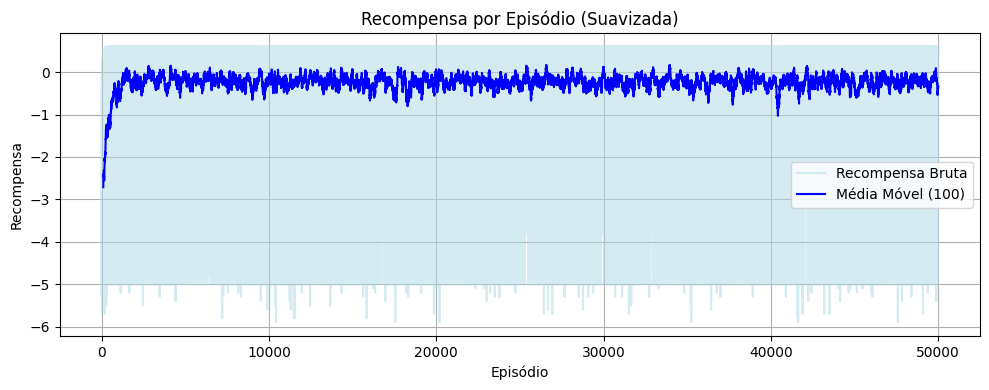

In [98]:
# Aplicar média móvel para suavizar a curva de recompensas por episódio

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 100
smoothed_rewards = moving_average(episode_rewards, window_size)

plt.figure(figsize=(10, 4))
plt.plot(episode_rewards, color='lightblue', alpha=0.5, label="Recompensa Bruta")
plt.plot(np.arange(window_size - 1, len(episode_rewards)), smoothed_rewards, color='blue', label=f"Média Móvel ({window_size})")
plt.xlabel("Episódio")
plt.ylabel("Recompensa")
plt.title("Recompensa por Episódio (Suavizada)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


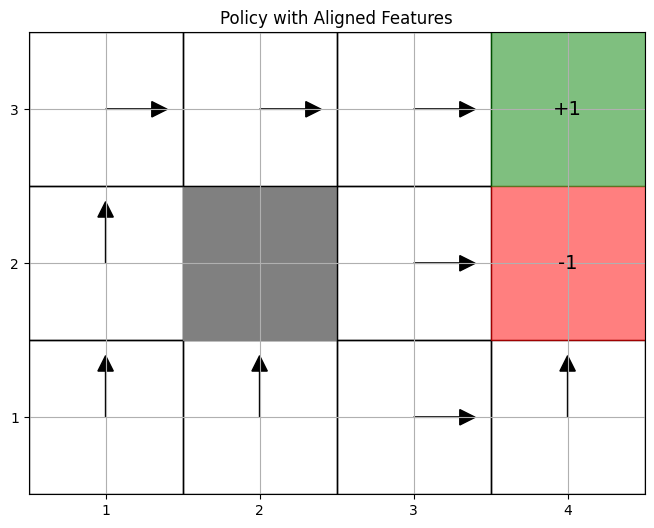

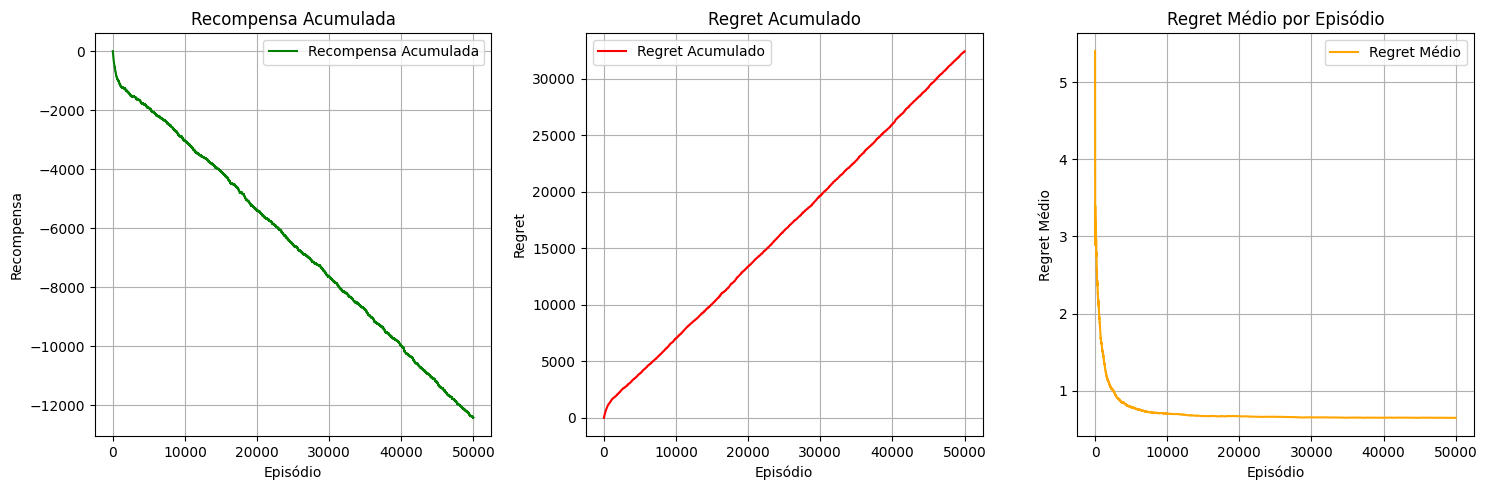

In [99]:
# Plot policy
policy = agent.get_policy()
fig, ax = plt.subplots(figsize=(8, 6))
arrow_dir = {'up': (0, 0.3), 'down': (0, -0.3), 'left': (-0.3, 0), 'right': (0.3, 0)}
for x in range(1, cols + 1):
    for y in range(1, rows + 1):
        pos = (x, y)
        if pos in walls:
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, color='gray'))
        elif pos in terminals:
            color = 'green' if terminals[pos] > 0 else 'red'
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, color=color, alpha=0.5))
            ax.text(x - 0.5, y - 0.5, f"{terminals[pos]:+.0f}", ha='center', va='center', fontsize=14)
        else:
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, edgecolor='black', fill=None))
            a = policy.get(pos, None)
            if a:
                dx, dy = arrow_dir[a]
                ax.arrow(x - 0.5, y - 0.5, dx, dy, head_width=0.1, head_length=0.1, color='black')
ax.set_xticks(np.arange(cols) + 0.5)
ax.set_yticks(np.arange(rows) + 0.5)
ax.set_xticklabels([str(x) for x in range(1, cols + 1)])
ax.set_yticklabels([str(y) for y in range(1, rows + 1)])
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid(True)
ax.set_title("Policy with Aligned Features")
plt.gca().set_aspect('equal')
plt.show()

# Plot performance
episode_rewards = np.array(episode_rewards)
regret = np.cumsum(0.4 - episode_rewards)
avg_regret = regret / np.arange(1, len(regret) + 1)
cumulative_rewards = np.cumsum(episode_rewards)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(cumulative_rewards, label="Recompensa Acumulada", color='green')
plt.xlabel("Episódio")
plt.ylabel("Recompensa")
plt.title("Recompensa Acumulada")
plt.grid(True)
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(regret, label="Regret Acumulado", color='red')
plt.xlabel("Episódio")
plt.ylabel("Regret")
plt.title("Regret Acumulado")
plt.grid(True)
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(avg_regret, label="Regret Médio", color='orange')
plt.xlabel("Episódio")
plt.ylabel("Regret Médio")
plt.title("Regret Médio por Episódio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()